In [ ]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from scipy.signal import savgol_filter
from scipy.stats import zscore
from scipy import sparse
from scipy.sparse.linalg import spsolve

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Mengambil spektrum dari semua sampel dan menggabungkan iterasi
def get_all_spectra(db_path, sample_names, lower_bound=350, upper_bound=400):
    all_spectra = {}
    for sample_name in sample_names:
        spectra = []
        for iteration in range(1, 4):  # Iterasi 1, 2, dan 3
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                spectra.append((wavelengths, intensities))
        all_spectra[sample_name] = spectra
    return all_spectra

# 1. Smoothing using Savitzky-Golay filter
def smooth_spectrum(intensity, window_length=11, polyorder=3):
    return savgol_filter(intensity, window_length, polyorder)

# 2. Baseline correction using ALS (Asymmetric Least Squares) with SciPy
def baseline_correction_als(intensity, lam=1e6, p=0.01, niter=10):
    L = len(intensity)
    D = sparse.diags([1, -2, 1], [0, 1, 2], shape=(L, L - 2))
    w = np.ones(L)
    for i in range(niter):
        W = sparse.diags(w, 0)
        Z = W + lam * D.dot(D.transpose())
        baseline = spsolve(Z, w * intensity)
        w = p * (intensity > baseline) + (1 - p) * (intensity < baseline)
    return baseline

# 3. Outlier removal using Z-score
def remove_outliers(intensity, threshold=3):
    z_scores = zscore(intensity)
    mask = np.abs(z_scores) < threshold
    return intensity[mask]

# 4. Normalisasi dengan PCA
def normalize_spectra_with_pca(spectra):
    # Gabungkan intensitas dari ketiga iterasi menjadi satu matriks
    combined_intensities = np.vstack([spectra[0][1], spectra[1][1], spectra[2][1]]).T

    # Terapkan PCA pada intensitas gabungan
    pca = PCA(n_components=1)  # Komponen pertama
    pc1 = pca.fit_transform(combined_intensities)

    # Normalisasi dengan komponen utama pertama
    iter1_pca_normalized = spectra[0][1] / np.abs(pc1).max()
    iter2_pca_normalized = spectra[1][1] / np.abs(pc1).max()
    iter3_pca_normalized = spectra[2][1] / np.abs(pc1).max()

    return [iter1_pca_normalized, iter2_pca_normalized, iter3_pca_normalized]

# 5. Rata-rata intensitas yang dinormalisasi
def average_normalized_spectra(wavelengths, normalized_intensities):
    avg_intensity = np.mean(normalized_intensities, axis=0)
    return wavelengths, avg_intensity

# Pipeline Proses Lengkap untuk 1 sampel dengan 3 iterasi
def process_spectrum_pipeline(wavelengths, intensities_list):
    # Gabungkan intensitas dari ketiga iterasi untuk diproses bersama
    processed_spectra = []
    
    for intensities in intensities_list:
        # 1. Smoothing
        smoothed_intensity = smooth_spectrum(intensities)
        
        # 2. Baseline Correction menggunakan ALS
        baseline = baseline_correction_als(smoothed_intensity)
        baseline_corrected_intensity = smoothed_intensity - baseline
        
        processed_spectra.append(baseline_corrected_intensity)
    
    # 3. Normalisasi dengan PCA (dengan komponen utama PC1)
    normalized_intensities = normalize_spectra_with_pca([(wavelengths, processed_spectra[0]),
                                                         (wavelengths, processed_spectra[1]),
                                                         (wavelengths, processed_spectra[2])])

    # 4. Removal Outliers dengan Z-score
    cleaned_intensities = [remove_outliers(intensity) for intensity in normalized_intensities]

    # 5. Rata-rata intensitas
    avg_intensity = average_normalized_spectra(wavelengths, cleaned_intensities)
    
    return avg_intensity

# Path ke database dan nama-nama sampel
db_path = 'tanah_vulkanik.db'
sample_names = [f'S{i}' for i in range(1, 7)]  # Contoh: 6 sampel

# Mengambil dan menggabungkan spektrum
all_spectra = get_all_spectra(db_path, sample_names)

# Normalisasi dan hitung rata-rata spektrum untuk setiap sampel
processed_spectra = {}
for sample_name, spectra in all_spectra.items():
    wavelengths = spectra[0][0]
    intensities_list = [s[1] for s in spectra]  # Mengambil intensitas dari ketiga iterasi
    
    # Proses ketiga iterasi menjadi satu spektrum per sampel
    avg_intensity = process_spectrum_pipeline(wavelengths, intensities_list)
    processed_spectra[sample_name] = avg_intensity

# Plot scatter dengan offset y untuk setiap sampel
plt.figure(figsize=(10, 6))
offset = 1  # Offset untuk setiap sampel pada sumbu y
for i, (sample_name, (wavelengths, avg_intensity)) in enumerate(processed_spectra.items()):
    plt.plot(wavelengths, avg_intensity + i * offset, label=f'{sample_name} (y offset {i * offset:.1f})', linewidth=0.4)

plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity (with y offset)')
plt.title('Normalized Spectra of Samples with ALS Baseline Correction')
plt.legend()
plt.grid(True)

# Save as PDF
plt.savefig('normalized_spectra_with_als.pdf', format='pdf')

# Show plot
plt.show()

In [ ]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from matplotlib.backends.backend_pdf import PdfPages

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Mengambil spektrum dari semua sampel dan menggabungkan iterasi
def get_all_spectra(db_path, sample_names, lower_bound=200, upper_bound=900):
    all_spectra = {}
    for sample_name in sample_names:
        spectra = []
        for iteration in range(1, 4):  # Iterasi 1, 2, dan 3
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                spectra.append((wavelengths, intensities))
        all_spectra[sample_name] = spectra
    return all_spectra

# Normalisasi dan rata-rata spektrum untuk rentang 200-900 nm
def normalize_and_average_spectra(all_spectra):
    normalized_averaged_spectra = {}

    for sample_name, spectra in all_spectra.items():
        if len(spectra) == 3:
            # Gabungkan intensitas dari ketiga iterasi menjadi satu matriks
            combined_intensities = np.vstack([spectra[0][1], spectra[1][1], spectra[2][1]]).T

            # Terapkan PCA pada intensitas gabungan
            pca = PCA(n_components=1)  # Komponen pertama
            pc1 = pca.fit_transform(combined_intensities)

            # Normalisasi setiap iterasi dengan komponen utama pertama (PC1)
            iter1_pca_normalized = spectra[0][1] / np.abs(pc1).max()
            iter2_pca_normalized = spectra[1][1] / np.abs(pc1).max()
            iter3_pca_normalized = spectra[2][1] / np.abs(pc1).max()

            # Hitung rata-rata intensitas dari ketiga iterasi yang dinormalisasi
            avg_intensity = np.mean([iter1_pca_normalized, iter2_pca_normalized, iter3_pca_normalized], axis=0)

            # Simpan hasil rata-rata intensitas dengan panjang gelombang
            normalized_averaged_spectra[sample_name] = (spectra[0][0], avg_intensity)

    return normalized_averaged_spectra

# Fungsi untuk memotong spektrum sesuai batas bawah dan atas yang diinginkan
def cut_spectra(normalized_averaged_spectra, lower_bound, upper_bound):
    cut_spectra = {}
    for sample_name, (wavelengths, avg_intensity) in normalized_averaged_spectra.items():
        mask = (wavelengths >= lower_bound) & (wavelengths <= upper_bound)
        cut_spectra[sample_name] = (wavelengths[mask], avg_intensity[mask])
    return cut_spectra

# Path ke database dan nama-nama sampel
db_path = 'tanah_vulkanik.db'

# Asumsi pembagian sampel, setiap tiga sampel mewakili satu lokasi dengan kedalaman 20cm, 40cm, dan 60cm
sample_groups = [
    [f'S{i}' for i in range(1, 4)],  # Lokasi 1: Pulo, Seulimum
    [f'S{i}' for i in range(4, 7)],  # Lokasi 2: Lam Apeng, Seulimum
    [f'S{i}' for i in range(7, 10)], # Lokasi 3: Leupung Bruek, Cot Glie
    [f'S{i}' for i in range(10, 13)],# Lokasi 4: Lambada, Seulimum
    [f'S{i}' for i in range(13, 16)],# Lokasi 5: Lon Baroh, Lembah Seulawah
    [f'S{i}' for i in range(16, 19)],# Lokasi 6: Teuladan, Lembah Seulawah
    [f'S{i}' for i in range(19, 22)],# Lokasi 7: Suka Damai, Lembah Seulawah
    [f'S{i}' for i in range(22, 25)] # Lokasi 8: Suka Mulia, Lembah Seulawah
]

# Informasi lokasi dan kedalaman yang sesuai
location_labels = [
    ('Pulo, Seulimum', ['40-60cm', '20-40cm', '0-20cm']),
    ('Lam Apeng, Seulimum', ['40-60cm', '20-40cm', '0-20cm']),
    ('Leupung Bruek, Cot Glie', ['40-60cm', '20-40cm', '0-20cm']),
    ('Lambada, Seulimum', ['40-60cm', '20-40cm', '0-20cm']),
    ('Lon Baroh, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm']),
    ('Teuladan, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm']),
    ('Suka Damai, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm']),
    ('Suka Mulia, Lembah Seulawah', ['40-60cm', '20-40cm', '0-20cm'])
]

# Sebelum loop untuk pembuatan file PDF
lo = 800  # Nilai lower bound yang diinginkan, bisa disesuaikan
upo = 900  # Nilai upper bound yang diinginkan, bisa disesuaikan

# Ganti pdfname dengan:
pdfname = f'normalized_spectra_offset_24_samples_labeled_{lo}_{upo}.pdf'

# Membuat file PDF dengan banyak halaman
with PdfPages(pdfname) as pdf:
    for group_idx, sample_group in enumerate(sample_groups):
        # Mengambil dan menggabungkan spektrum untuk setiap lokasi
        all_spectra = get_all_spectra(db_path, sample_group, lower_bound=200, upper_bound=900)
        
        # Normalisasi dan hitung rata-rata spektrum untuk setiap sampel di rentang 200-900 nm
        normalized_averaged_spectra = normalize_and_average_spectra(all_spectra)

        # Potong spektrum sesuai dengan lower_bound dan upper_bound yang diinginkan
        cut_normalized_spectra = cut_spectra(normalized_averaged_spectra, lo, upo)

        # Plot setiap sampel dengan y-offset pada halaman yang berbeda
        plt.figure(figsize=(12, 8))
        offset = 1 # Offset untuk setiap sampel pada sumbu y
        for i, (sample_name, (wavelengths, avg_intensity)) in enumerate(cut_normalized_spectra.items()):
            plt.plot(wavelengths, avg_intensity + i * offset, label=f'{sample_name} ({location_labels[group_idx][1][i]})', linewidth=0.4)

        plt.ylim(0, 3)  # Batas sumbu y di antara 0 dan 4
        plt.xlabel('Wavelength (nm)')
        plt.ylabel('Normalized Intensity (with y offset)')
        plt.title(f'Normalized Spectra of Samples from {location_labels[group_idx][0]}')
        plt.legend()
        plt.grid(True)

        # Simpan halaman ini ke file PDF
        pdf.savefig()
        plt.close()

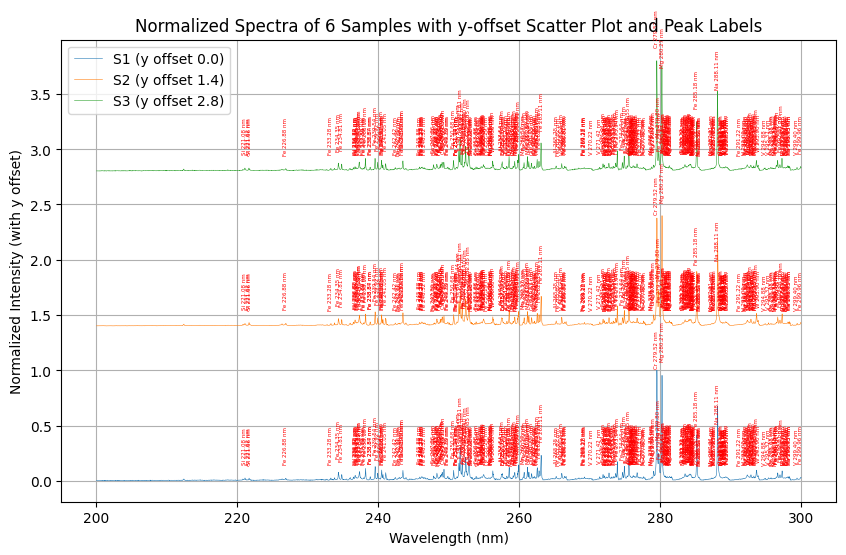

In [3]:
import sqlite3
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Mengambil spektrum dari semua sampel dan menggabungkan iterasi
def get_all_spectra(db_path, sample_names, lower_bound=200, upper_bound=300):
    all_spectra = {}
    for sample_name in sample_names:
        spectra = []
        for iteration in range(1, 4):  # Iterasi 1, 2, dan 3
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                spectra.append((wavelengths, intensities))
        all_spectra[sample_name] = spectra
    return all_spectra

# Normalisasi dan rata-rata spektrum
def normalize_and_average_spectra(all_spectra):
    normalized_averaged_spectra = {}
    scaler = MinMaxScaler()
    
    for sample_name, spectra in all_spectra.items():
        if len(spectra) == 3:
            # Normalisasi setiap iterasi menggunakan MinMaxScaler
            iter1_normalized = scaler.fit_transform(spectra[0][1].reshape(-1, 1)).flatten()
            iter2_normalized = scaler.fit_transform(spectra[1][1].reshape(-1, 1)).flatten()
            iter3_normalized = scaler.fit_transform(spectra[2][1].reshape(-1, 1)).flatten()

            # Hitung rata-rata intensitas dari ketiga iterasi
            avg_intensity = np.mean([iter1_normalized, iter2_normalized, iter3_normalized], axis=0)

            # Simpan hasil rata-rata intensitas
            normalized_averaged_spectra[sample_name] = (spectra[0][0], avg_intensity)
    
    return normalized_averaged_spectra

# Fungsi untuk membaca file puncak terpilih (misalkan dalam format teks)
# Fungsi untuk membaca file puncak terpilih (dengan skip 4 baris pertama)
def read_peak_file(peak_file):
    peaks = []
    with open(peak_file, 'r') as file:
        lines = file.readlines()[4:]  # Skip 4 baris pertama
        for line in lines:
            parts = line.strip().split()
            if len(parts) >= 3:
                element = parts[0]
                wavelength = float(parts[2])
                peaks.append((element, wavelength))
    return peaks

# Fungsi untuk mencari puncak terdekat di spektrum eksperimen
def find_nearest_peak(experimental_wavelengths, peak_wavelength):
    idx = (np.abs(experimental_wavelengths - peak_wavelength)).argmin()
    return idx, experimental_wavelengths[idx]

# Path ke database dan nama-nama sampel
db_path = 'tanah_vulkanik.db'
sample_names = [f'S{i}' for i in range(1, 4)]  # Contoh: 6 sampel

# Mengambil dan menggabungkan spektrum
all_spectra = get_all_spectra(db_path, sample_names)

# Normalisasi dan hitung rata-rata spektrum untuk setiap sampel
normalized_averaged_spectra = normalize_and_average_spectra(all_spectra)

# Path ke file puncak terpilih (misalkan dalam format teks)
peak_file_path = '/Users/birrulwalidain/PycharmProjects/proyek-lIbs/S1(900.0-200.0)(0.5)(0920-0906).txt'

# Baca puncak terpilih dari file
peaks = read_peak_file(peak_file_path)

# Plot scatter dengan offset y untuk setiap sampel
plt.figure(figsize=(10, 6))
offset = 1.4  # Offset untuk setiap sampel pada sumbu y
for i, (sample_name, (wavelengths, avg_intensity)) in enumerate(normalized_averaged_spectra.items()):
    plt.plot(wavelengths, avg_intensity + i * offset, label=f'{sample_name} (y offset {i * offset:.1f})', linewidth=0.4)

    # Tambahkan label untuk setiap puncak terpilih
    for element, peak_wavelength in peaks:
        idx, nearest_wavelength = find_nearest_peak(wavelengths, peak_wavelength)
        plt.annotate(f'{element} {nearest_wavelength:.2f} nm', 
                     (nearest_wavelength, avg_intensity[idx] + i * offset),
                     textcoords="offset points", xytext=(0, 10), ha='center',va='bottom', fontsize=4, color='red', rotation='vertical')
        #plt.scatter(nearest_wavelength, avg_intensity[idx] + i * offset, color='red')

plt.xlabel('Wavelength (nm)')
plt.ylabel('Normalized Intensity (with y offset)')
plt.title('Normalized Spectra of 6 Samples with y-offset Scatter Plot and Peak Labels')
plt.legend()
plt.grid(True)

# Save as PDF
plt.savefig('normalized_spectra_with_peaks.pdf', format='pdf')

# Show plot
plt.show()

In [31]:
import sqlite3

# Fungsi untuk menambahkan kolom 'depth', 'location', dan 'location_point' ke tabel spektrum
def add_columns_to_table(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Menambahkan kolom 'depth' jika belum ada
    try:
        cursor.execute("ALTER TABLE spectrum_data ADD COLUMN depth TEXT")
        print("Kolom 'depth' berhasil ditambahkan.")
    except sqlite3.OperationalError:
        print("Kolom 'depth' sudah ada.")

    # Menambahkan kolom 'location' jika belum ada
    try:
        cursor.execute("ALTER TABLE spectrum_data ADD COLUMN location TEXT")
        print("Kolom 'location' berhasil ditambahkan.")
    except sqlite3.OperationalError:
        print("Kolom 'location' sudah ada.")
    
    # Menambahkan kolom 'location_point' untuk titik lokasi
    try:
        cursor.execute("ALTER TABLE spectrum_data ADD COLUMN location_point TEXT")
        print("Kolom 'location_point' berhasil ditambahkan.")
    except sqlite3.OperationalError:
        print("Kolom 'location_point' sudah ada.")

    conn.commit()
    conn.close()

# Fungsi untuk memperbarui data spektrum dengan kedalaman, lokasi, dan titik lokasi
def update_sample_info(db_path):
    # Data kedalaman, lokasi, dan titik lokasi untuk setiap sampel
    sample_info = {
        'S1': ('40-60', 'Pulo, Seulimum', 'A'),
        'S2': ('20-40', 'Pulo, Seulimum', 'A'),
        'S3': ('0-20', 'Pulo, Seulimum', 'A'),
        'S4': ('40-60', 'Lam Apeng, Seulimum', 'B'),
        'S5': ('20-40', 'Lam Apeng, Seulimum', 'B'),
        'S6': ('0-20', 'Lam Apeng, Seulimum', 'B'),
        'S7': ('40-60', 'Leupung Bruek, Cot Glie', 'A'),
        'S8': ('20-40', 'Leupung Bruek, Cot Glie', 'A'),
        'S9': ('0-20', 'Leupung Bruek, Cot Glie', 'A'),
        'S10': ('40-60', 'Lambada, Seulimum', 'B'),
        'S11': ('20-40', 'Lambada, Seulimum', 'B'),
        'S12': ('0-20', 'Lambada, Seulimum', 'B'),
        'S13': ('40-60', 'Lon Baroh, Lembah Seulawah', 'B'),
        'S14': ('20-40', 'Lon Baroh, Lembah Seulawah', 'B'),
        'S15': ('0-20', 'Lon Baroh, Lembah Seulawah', 'B'),
        'S16': ('40-60', 'Teuladan, Lembah Seulawah', 'A'),
        'S17': ('20-40', 'Teuladan, Lembah Seulawah', 'A'),
        'S18': ('0-20', 'Teuladan, Lembah Seulawah', 'A'),
        'S19': ('40-60', 'Suka Damai, Lembah Seulawah', 'A'),
        'S20': ('20-40', 'Suka Damai, Lembah Seulawah', 'A'),
        'S21': ('0-20', 'Suka Damai, Lembah Seulawah', 'A'),
        'S22': ('40-60', 'Suka Mulia, Lembah Seulawah', 'B'),
        'S23': ('20-40', 'Suka Mulia, Lembah Seulawah', 'B'),
        'S24': ('0-20', 'Suka Mulia, Lembah Seulawah', 'B')
    }

    # Memperbarui data spektrum dengan kedalaman, lokasi, dan titik lokasi
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    for sample_name, (depth, location, location_point) in sample_info.items():
        cursor.execute("""
            UPDATE spectrum_data
            SET depth = ?, location = ?, location_point = ?
            WHERE sample_name = ?
        """, (depth, location, location_point, sample_name))

    conn.commit()
    conn.close()
    print("Data sampel berhasil diperbarui dengan kedalaman, lokasi, dan titik lokasi.")

# Fungsi untuk menampilkan data setelah diperbarui
def verify_updates(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    cursor.execute("SELECT sample_name, depth, location, location_point FROM spectrum_data")
    rows = cursor.fetchall()

    for row in rows:
        print(row)

    conn.close()

# Path ke database
db_path = 'tanah_vulkanik.db'

# Menambahkan kolom depth, location, dan location_point
add_columns_to_table(db_path)

# Memperbarui informasi sampel dengan kedalaman, lokasi, dan titik lokasi
update_sample_info(db_path)

# Verifikasi pembaruan
verify_updates(db_path)

Kolom 'depth' sudah ada.
Kolom 'location' sudah ada.
Kolom 'location_point' berhasil ditambahkan.
Data sampel berhasil diperbarui dengan kedalaman, lokasi, dan titik lokasi.


IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-40', 'Lon Baroh, Lembah Seulawah', 'B')
('S14', '20-

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



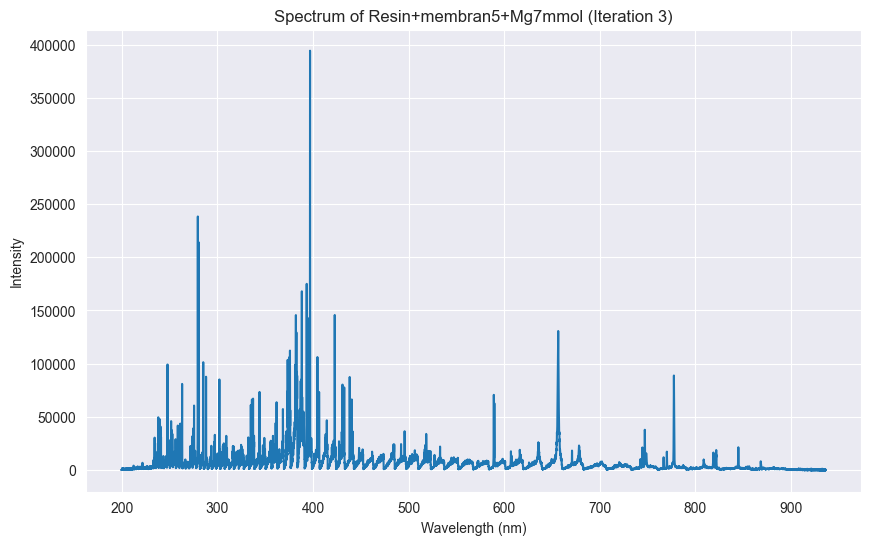

In [1]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum dari database
def get_spectrum_with_metadata(db_path, sample_name, iteration):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Ambil spektrum berdasarkan sample_name dan iteration
    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name, iteration))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    # Pisahkan panjang gelombang dan intensitas
    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk membuat plot spektrum
def plot_spectrum_with_metadata(db_path, sample_name, iteration):
    wavelengths, intensities = get_spectrum_with_metadata(db_path, sample_name, iteration)

    if len(wavelengths) == 0:
        return  # Tidak ada data yang ditemukan

    # Plot spektrum
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities)
    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(f'Spectrum of {sample_name} (Iteration {iteration})')
    plt.grid(True)
    plt.show()

# Path ke database
db_path = 'kopi3.db'

# Contoh plot spektrum dari salah satu sampel
sample_name = 'Resin+membran5+Mg7mmol'
iteration = 3

# Plot spektrum
plot_spectrum_with_metadata(db_path, sample_name, iteration)

In [2]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Fungsi untuk mengambil spektrum dari database
def spec(db_path, sample_name, iteration, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM spectrum_data
        WHERE sample_name = ? AND iteration = ?
    """
    params = [sample_name, iteration]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No data found for sample: {sample_name}, iteration: {iteration}")
        return np.array([]), np.array([])

    # Pisahkan panjang gelombang dan intensitas
    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# SNIP (Statistics-Sensitive Non-Linear Iterative Peak-Clipping) baseline correction
def baseline_correction_snip(intensity, iterations=100):
    L = len(intensity)
    baseline = np.copy(intensity)

    for i in range(iterations):
        for j in range(1, L - 1):
            baseline[j] = min(baseline[j], (baseline[j - 1] + baseline[j + 1]) / 2)
    return baseline

# Fungsi normalisasi dengan PCA
def normalize_spectra_with_pca(spectra):
    # Gabungkan intensitas dari iterasi yang tersedia menjadi satu matriks
    combined_intensities = np.vstack([s[1] for s in spectra]).T

    # Terapkan PCA pada intensitas gabungan
    pca = PCA(n_components=1)  # Komponen pertama
    pc1 = pca.fit_transform(combined_intensities)

    # Normalisasi setiap iterasi dengan komponen utama pertama
    normalized_intensities = [s[1] / np.abs(pc1).max() for s in spectra]

    return normalized_intensities

# Fungsi untuk menghitung rata-rata intensitas dari beberapa iterasi
def average_normalized_spectra(wavelengths, normalized_intensities):
    avg_intensity = np.mean(normalized_intensities, axis=0)
    return wavelengths, avg_intensity

# Menyimpan hasil yang diproses ke database baru
def save_to_new_db(db_path, processed_data):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Membuat tabel baru jika belum ada
    cursor.execute("""
        CREATE TABLE IF NOT EXISTS processed_spectrum (
            sample_name TEXT,
            wavelength REAL,
            intensity REAL
        )
    """)

    # Menyimpan data yang telah diproses
    for sample_name, (wavelengths, intensities) in processed_data.items():
        for wavelength, intensity in zip(wavelengths, intensities):
            cursor.execute("""
                INSERT INTO processed_spectrum (sample_name, wavelength, intensity)
                VALUES (?, ?, ?)
            """, (sample_name, wavelength, intensity))
    
    conn.commit()
    conn.close()

# Mengambil spektrum dari semua sampel, melakukan baseline correction (opsional), normalisasi, dan PCA
def get_and_process_spectra(db_path, sample_names, lower_bound=200, upper_bound=900, use_baseline_correction=True):
    processed_spectra = {}
    for sample_name in sample_names:
        spectra = []
        # Loop through iterations (assuming max 3 iterations, but handle 2 iterations)
        for iteration in range(1, 4):  # Iterasi 1, 2, dan 3
            wavelengths, intensities = spec(db_path, sample_name, iteration, lower_bound, upper_bound)
            if len(wavelengths) > 0:
                if use_baseline_correction:
                    # Baseline correction menggunakan SNIP jika diaktifkan
                    baseline = baseline_correction_snip(intensities)
                    baseline_corrected_intensity = intensities - baseline
                    spectra.append((wavelengths, baseline_corrected_intensity))
                else:
                    # Langsung gunakan intensitas tanpa baseline correction
                    spectra.append((wavelengths, intensities))

        # Jika ada minimal 2 iterasi, lanjutkan
        if len(spectra) >= 2:
            # Normalisasi setiap iterasi menggunakan PCA
            normalized_intensities = normalize_spectra_with_pca(spectra)

            # Hitung rata-rata intensitas yang dinormalisasi
            wavelengths, avg_intensity = average_normalized_spectra(wavelengths, normalized_intensities)

            # Simpan data yang diproses
            processed_spectra[sample_name] = (wavelengths, avg_intensity)
        else:
            print(f"Skipping sample {sample_name} due to incomplete data across iterations.")

    return processed_spectra

# Path ke database lama dan database baru
old_db_path = 'kopi3.db'
new_db_path = 'kopi4.db'
sample_names = [f'Resin+membran5+Mg{i}mmol' for i in range(1, 8)]  # 7 sampel

# Pilih apakah akan menggunakan baseline correction atau tidak
use_baseline_correction = True  # Atur False jika tidak ingin menggunakan baseline correction

# Mengambil dan memproses spektrum
processed_spectra = get_and_process_spectra(old_db_path, sample_names, use_baseline_correction=use_baseline_correction)

# Simpan hasil yang telah diproses ke database baru
save_to_new_db(new_db_path, processed_spectra)

print(f"Data spektrum yang diproses telah disimpan ke {new_db_path}")

No data found for sample: Resin+membran5+Mg6mmol, iteration: 1
No data found for sample: Resin+membran5+Mg6mmol, iteration: 2
No data found for sample: Resin+membran5+Mg6mmol, iteration: 3
Skipping sample Resin+membran5+Mg6mmol due to incomplete data across iterations.
Data spektrum yang diproses telah disimpan ke kopi4.db


In [4]:
import sqlite3

# Fungsi untuk memeriksa sample_name yang telah disimpan di database kopi4.db
def check_sample_names_in_processed_spectrum(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mengambil semua sample_name yang disimpan di tabel processed_spectrum
    query = """
        SELECT DISTINCT sample_name
        FROM processed_spectrum
    """
    cursor.execute(query)
    sample_names = cursor.fetchall()
    conn.close()

    # Tampilkan sample_name yang ditemukan
    if sample_names:
        print("Sample names stored in 'processed_spectrum':")
        for name in sample_names:
            print(name[0])
    else:
        print("No sample names found in 'processed_spectrum'.")

# Path ke database kopi4.db
db_path = 'kopi4.db'

# Panggil fungsi untuk memeriksa sample_name yang disimpan di processed_spectrum
check_sample_names_in_processed_spectrum(db_path)

Sample names stored in 'processed_spectrum':
Resin+membran5+Mg1mmol
Resin+membran5+Mg3mmol
Resin+membran5+Mg4mmol
Resin+membran5+Mg5mmol
Resin+membran5+Mg7mmol


PROSES 2

Tidak ada data yang ditemukan untuk sampel: Resin+membran5+Mg6mmol


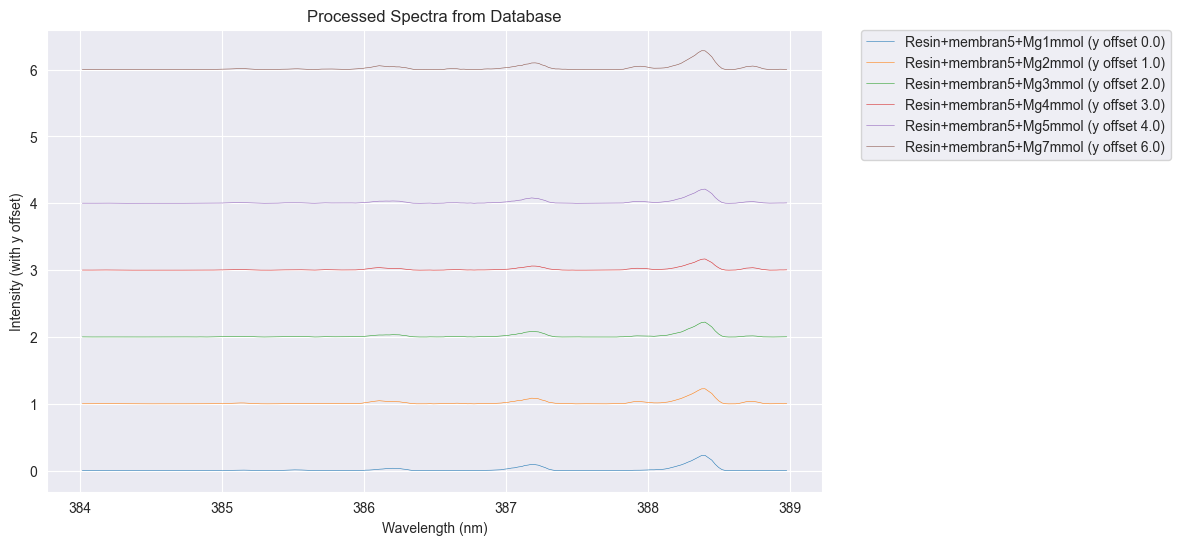

Daftar Puncak Spektrum dalam Rentang Panjang Gelombang:
Sample Name                    Peak Wavelength (nm)      Peak Intensity 
Resin+membran5+Mg1mmol         388.4011                  0.2297         
Resin+membran5+Mg2mmol         388.4011                  0.2260         
Resin+membran5+Mg3mmol         388.4011                  0.2229         
Resin+membran5+Mg4mmol         388.4011                  0.1675         
Resin+membran5+Mg5mmol         388.4011                  0.2121         
Tidak ada data yang ditemukan untuk sampel: Resin+membran5+Mg6mmol
Resin+membran5+Mg6mmol         N/A                       N/A            
Resin+membran5+Mg7mmol         388.3771                  0.2821         
Plot spektrum yang diproses telah disimpan dalam format PDF.


In [8]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum yang telah diproses dari database
def get_processed_spectra(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang ke dalam query jika ditentukan
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([])

    # Pisahkan panjang gelombang dan intensitas
    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk plotting spektrum dari database dan menyimpan hasilnya dalam format PDF
def plot_and_save_processed_spectra(db_path, sample_names, output_pdf='processed_spectra_plot.pdf', lower_bound=None, upper_bound=None):
    plt.figure(figsize=(10, 6))
    offset = 1  # Offset untuk setiap sampel pada sumbu y
    for i, sample_name in enumerate(sample_names):
        wavelengths, intensities = get_processed_spectra(db_path, sample_name, lower_bound, upper_bound)
        if len(wavelengths) > 0:
            # Menambahkan offset ke intensitas untuk membedakan antar sampel pada plot
            plt.plot(wavelengths, intensities + i * offset, label=f'{sample_name} (y offset {i * offset:.1f})', linewidth=0.4)

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (with y offset)')
    plt.title('Processed Spectra from Database')

    # Menempatkan legenda di luar kotak plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.grid(True)

    # Menyimpan plot ke dalam file PDF
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

    # Menampilkan plot
    plt.show()

# Fungsi untuk mencetak daftar puncak spektrum dari setiap sampel
def print_peak_list(db_path, sample_names, lower_bound=None, upper_bound=None):
    print("Daftar Puncak Spektrum dalam Rentang Panjang Gelombang:")
    print(f"{'Sample Name':<30} {'Peak Wavelength (nm)':<25} {'Peak Intensity':<15}")
    print("=" * 70)

    for sample_name in sample_names:
        wavelengths, intensities = get_processed_spectra(db_path, sample_name, lower_bound, upper_bound)
        if len(wavelengths) > 0:
            # Cari puncak intensitas
            peak_index = np.argmax(intensities)
            peak_wavelength = wavelengths[peak_index]
            peak_intensity = intensities[peak_index]

            # Print hasil puncak
            print(f"{sample_name:<30} {peak_wavelength:<25.4f} {peak_intensity:<15.4f}")
        else:
            print(f"{sample_name:<30} {'N/A':<25} {'N/A':<15}")

# Path ke database baru
db_path = 'kopi4.db'
sample_names = [f'Resin+membran5+Mg{i}mmol' for i in range(1, 8)]  # 7 sampel

# Menentukan batas panjang gelombang
lower_bound = 384  # Contoh: batas bawah panjang gelombang
upper_bound = 389  # Contoh: batas atas panjang gelombang

# Memproses dan menyimpan spektrum dengan batas panjang gelombang ke PDF
plot_and_save_processed_spectra(db_path, sample_names, 'processed_spectra_plot_with_bounds.pdf', lower_bound, upper_bound)

# Mencetak daftar puncak dari spektrum berdasarkan rentang panjang gelombang
print_peak_list(db_path, sample_names, lower_bound, upper_bound)

print("Plot spektrum yang diproses telah disimpan dalam format PDF.")

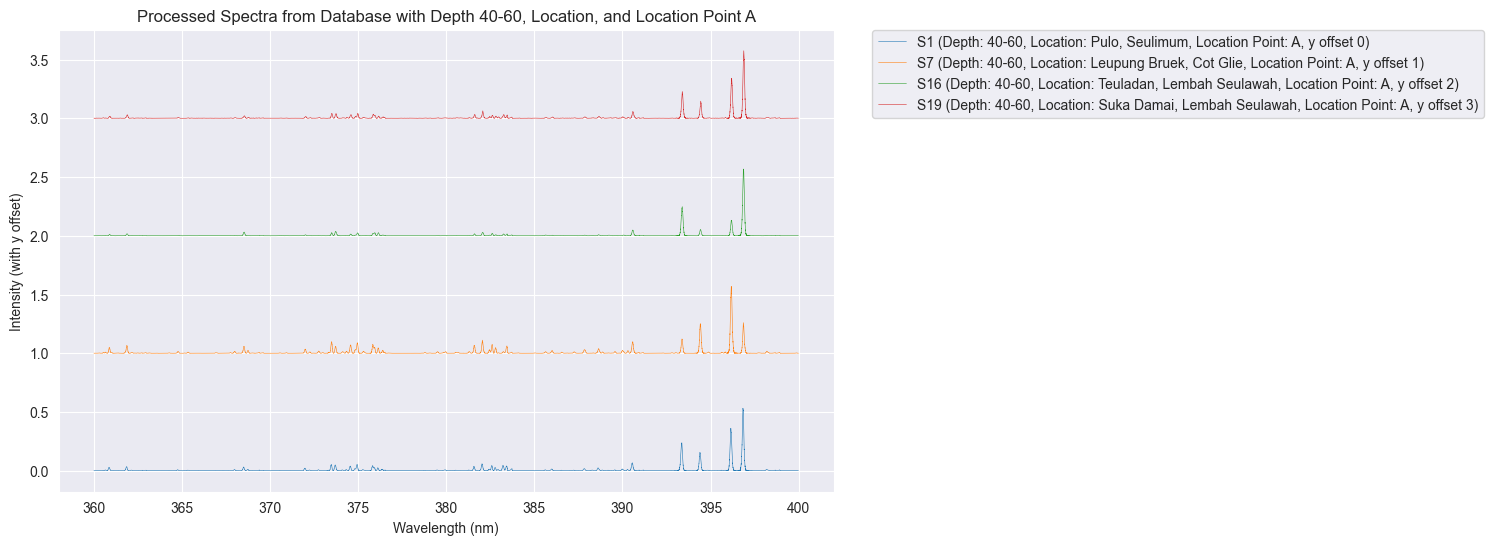

Plot spektrum yang diproses telah disimpan dalam format PDF dengan filter location_point A dan depth 40-60.


In [5]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth, location, dan location_point
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang ke dalam query jika ditentukan
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan location_point
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk plotting spektrum dari database dan menyimpan hasilnya dalam format PDF
def plot_and_save_processed_spectra(db_path, sample_names, output_pdf='processed_spectra_plot_with_metadata.pdf', lower_bound=None, upper_bound=None):
    plt.figure(figsize=(10, 6))
    offset = 1  # Offset tetap untuk setiap spektrum pada sumbu y
    plot_counter = 0  # Counter untuk menentukan berapa banyak spektrum yang sudah diplot
    
    for sample_name in sample_names:
        wavelengths, intensities, depth, location, location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)
        
        # Filter hanya untuk location_point A dan depth 40-60
        if location_point == 'A' and depth == '40-60' and len(wavelengths) > 0:
            # Menambahkan depth, location, dan location_point ke label pada plot
            plt.plot(wavelengths, intensities + plot_counter * offset, label=f'{sample_name} (Depth: {depth}, Location: {location}, Location Point: {location_point}, y offset {plot_counter * offset})', linewidth=0.4)
            plot_counter += 1  # Increment plot counter untuk offset berikutnya

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity (with y offset)')
    plt.title('Processed Spectra from Database with Depth 40-60, Location, and Location Point A')

    # Meletakkan legenda di luar kotak plot
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.grid(True)

    # Menyimpan plot ke dalam file PDF
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight')

    # Menampilkan plot
    plt.show()

# Path ke database baru
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 25)]  # Semua sampel

# Menentukan batas panjang gelombang
lower_bound = 360  # Contoh: batas bawah panjang gelombang
upper_bound = 400  # Contoh: batas atas panjang gelombang

# Memproses dan menyimpan spektrum dengan batas panjang gelombang ke PDF, dengan location_point A dan depth 40-60
plot_and_save_processed_spectra(db_path, sample_names, 'processed_spectra_plot_A_40-60.pdf', lower_bound, upper_bound)

print("Plot spektrum yang diproses telah disimpan dalam format PDF dengan filter location_point A dan depth 40-60.")

PROSES 3

In [9]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth, location, dan location_point
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location, location_point
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    # Menambahkan batas panjang gelombang ke dalam query jika ditentukan
    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None, None

    # Pisahkan panjang gelombang, intensitas, kedalaman, lokasi, dan location_point
    wavelengths, intensities, depth, location, location_point = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0], location_point[0]

# Fungsi untuk plotting spektrum dari database dan menyimpan hasilnya dalam format PDF
def plot_and_save_all_depths_location_points(db_path, sample_names, output_pdf='processed_spectra_all_depths_location_points.pdf', lower_bound=None, upper_bound=None):
    # Daftar depth dan location_point yang akan di-plot
    depths = ['0-20', '20-40', '40-60']
    location_points = ['A', 'B']
    
    with PdfPages(output_pdf) as pdf:
        for location_point in location_points:
            for depth in depths:
                plt.figure(figsize=(10, 6))
                offset = 1  # Offset tetap untuk setiap spektrum pada sumbu y
                plot_counter = 0  # Counter untuk menentukan berapa banyak spektrum yang sudah diplot
                
                for sample_name in sample_names:
                    wavelengths, intensities, sample_depth, location, sample_location_point = get_processed_spectra_with_metadata(db_path, sample_name, lower_bound, upper_bound)

                    # Filter berdasarkan location_point dan depth
                    if sample_location_point == location_point and sample_depth == depth and len(wavelengths) > 0:
                        # Menambahkan depth, location, dan location_point ke label pada plot
                        plt.plot(wavelengths, intensities + plot_counter * offset, label=f'{sample_name} (Depth: {depth}, Location: {location}, Location Point: {location_point}, y offset {plot_counter * offset})', linewidth=0.4)
                        plot_counter += 1  # Increment plot counter untuk offset berikutnya

                plt.xlabel('Wavelength (nm)')
                plt.ylabel('Intensity (with y offset)')
                plt.title(f'Processed Spectra with Depth {depth}, Location Point {location_point}')

                # Atur sumbu Y konsisten dari 0 hingga 4
                plt.ylim(0, 4)

                # Meletakkan legenda di luar kotak plot
                plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

                plt.grid(True)

                # Menyimpan halaman ke dalam file PDF
                pdf.savefig(bbox_inches='tight')

                # Menutup halaman saat ini
                plt.close()

# Path ke database baru
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 25)]  # Semua sampel

# Menentukan batas panjang gelombang
lower_bound = 396  # Contoh: batas bawah panjang gelombang
upper_bound = 398  # Contoh: batas atas panjang gelombang

# Memproses dan menyimpan spektrum untuk seluruh depth dan location_point ke file PDF
plot_and_save_all_depths_location_points(db_path, sample_names, 'processed_spectra_all_depths_location_points.pdf', lower_bound, upper_bound)

print("Plot spektrum yang diproses telah disimpan dalam satu file PDF dengan seluruh kombinasi depth dan location_point.")

Plot spektrum yang diproses telah disimpan dalam satu file PDF dengan seluruh kombinasi depth dan location_point.


In [6]:
import sqlite3
import numpy as np
import pandas as pd

# Fungsi untuk mengambil spektrum yang telah diproses dari database
def get_processed_spectra(db_path, sample_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
        ORDER BY wavelength
    """
    cursor.execute(query, (sample_name,))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"No processed data found for sample: {sample_name}")
        return np.array([]), np.array([])
    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk mengakses spektrum dari semua sampel dan menyimpannya ke dalam Excel
def export_spectra_to_excel(db_path, sample_names, output_excel):
    all_data = {}  # Dictionary untuk menyimpan semua spektrum
    
    for sample_name in sample_names:
        wavelengths, intensities = get_processed_spectra(db_path, sample_name)
        if len(wavelengths) > 0:
            # Simpan spektrum dalam dictionary, dengan kunci sample_name
            all_data[sample_name] = intensities

    # Membuat DataFrame untuk diekspor ke Excel
    df = pd.DataFrame({
        'Wavelength': wavelengths  # Panjang gelombang hanya sekali
    })

    # Tambahkan setiap sampel ke DataFrame sebagai kolom
    for sample_name in sample_names:
        df[sample_name] = all_data.get(sample_name, np.nan)  # Mengisi NaN jika spektrum tidak ada

    # Ekspor ke file Excel
    df.to_excel(output_excel, index=False)
    print(f"Data berhasil diekspor ke {output_excel}")

# Path ke database baru dan nama file output Excel
db_path = 'kopi4.db'
output_excel = 'mgm.xlsx'
sample_names = [f'Resin+membran5+Mg{i}mmol' for i in range(1, 8)]  # 7 sampel

# Ekspor data ke Excel
export_spectra_to_excel(db_path, sample_names, output_excel)

No processed data found for sample: Resin+membran5+Mg6mmol
Data berhasil diekspor ke mgm.xlsx


proses 4

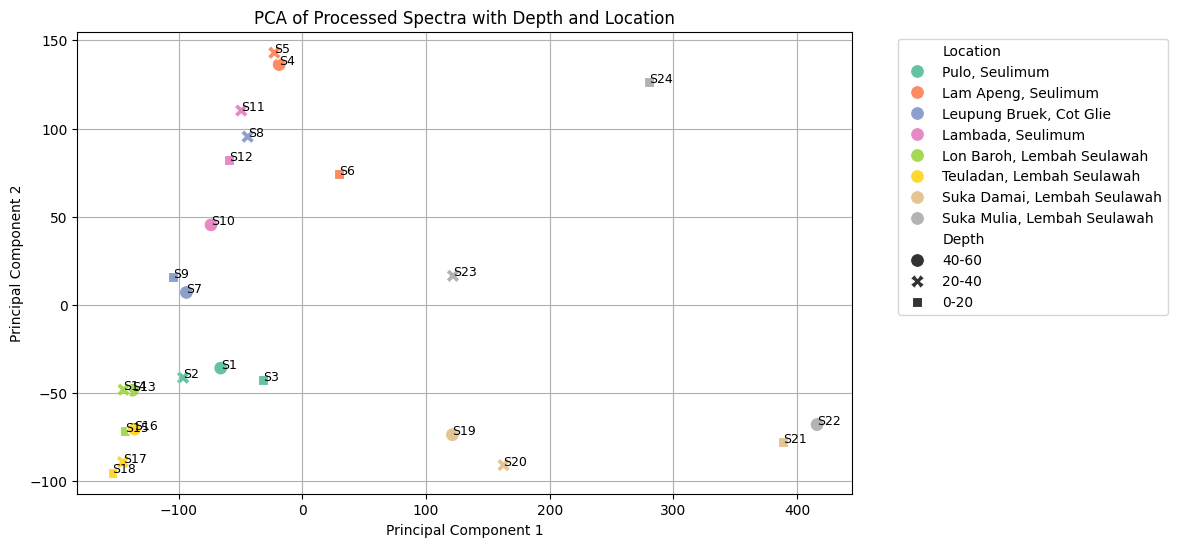

Plot PCA dengan depth dan location telah disimpan dalam bentuk PDF.


In [30]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Fungsi untuk mengambil spektrum yang telah diproses dari database, termasuk depth dan location
def get_all_spectra_with_metadata(db_path, sample_names):
    all_spectra = []
    metadata = []
    
    for sample_name in sample_names:
        conn = sqlite3.connect(db_path)
        cursor = conn.cursor()

        query = """
            SELECT wavelength, intensity, depth, location
            FROM processed_spectrum
            WHERE sample_name = ?
            ORDER BY wavelength
        """
        cursor.execute(query, (sample_name,))
        data = cursor.fetchall()
        conn.close()

        if data:
            wavelengths, intensities, depth, location = zip(*data)
            all_spectra.append(np.array(intensities))  # Simpan hanya intensitas
            metadata.append((depth[0], location[0]))   # Simpan depth dan location
        else:
            print(f"No processed data found for sample: {sample_name}")
            all_spectra.append(np.array([]))
            metadata.append((None, None))  # Menambahkan placeholder jika tidak ada data

    return np.array(all_spectra), metadata

# Fungsi untuk melakukan PCA dan plot hasilnya dengan bentuk dan warna sesuai depth dan location
def perform_pca_and_plot(db_path, sample_names, output_pdf='pca_plot_with_depth_location.pdf'):
    # Mengambil spektrum dan metadata dari semua sampel
    spectra, metadata = get_all_spectra_with_metadata(db_path, sample_names)
    
    # Menghapus spektrum yang kosong (jika ada)
    non_empty_spectra = [spec for spec in spectra if spec.size > 0]
    sample_names_filtered = [sample_names[i] for i in range(len(spectra)) if spectra[i].size > 0]
    metadata_filtered = [metadata[i] for i in range(len(spectra)) if spectra[i].size > 0]
    
    # Standarisasi data spektrum (mean = 0, variance = 1)
    scaler = StandardScaler()
    spectra_scaled = scaler.fit_transform(non_empty_spectra)

    # Melakukan PCA
    pca = PCA(n_components=2)  # Mengambil 2 komponen utama pertama
    principal_components = pca.fit_transform(spectra_scaled)

    # Membuat DataFrame untuk memvisualisasikan hasil PCA
    pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
    pca_df['Sample'] = sample_names_filtered
    pca_df['Depth'] = [meta[0] for meta in metadata_filtered]
    pca_df['Location'] = [meta[1] for meta in metadata_filtered]

    # Plot hasil PCA dengan seaborn, menggunakan warna berdasarkan lokasi dan bentuk berdasarkan kedalaman
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Location', style='Depth', palette='Set2', s=100)

    for i, sample_name in enumerate(pca_df['Sample']):
        plt.text(pca_df['PC1'][i], pca_df['PC2'][i], sample_name, fontsize=9)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.title('PCA of Processed Spectra with Depth and Location')
    plt.grid(True)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')  # Letakkan legend di luar plot

    # Menyimpan plot ke dalam file PDF
    plt.savefig(output_pdf, format='pdf', bbox_inches='tight', dpi=300)

    # Menampilkan plot
    plt.show()

# Path ke database baru dan daftar nama sampel
db_path = 'processed_spectra.db'
sample_names = [f'S{i}' for i in range(1, 25)]  # 24 sampel

# Melakukan PCA dan plot hasilnya serta menyimpan ke dalam PDF
perform_pca_and_plot(db_path, sample_names, 'pca_plot_with_depth_location.pdf')

print("Plot PCA dengan depth dan location telah disimpan dalam bentuk PDF.")

In [3]:
import sqlite3

# Fungsi untuk menampilkan nama kolom dari tabel tertentu
def get_table_headers(db_path, table_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mendapatkan informasi kolom dari tabel tertentu
    cursor.execute(f"PRAGMA table_info({table_name})")
    columns = cursor.fetchall()
    conn.close()

    # Cek apakah ada kolom yang ditemukan
    if not columns:
        print(f"Tidak ada kolom ditemukan di tabel: {table_name}")
    else:
        print(f"Nama kolom di tabel '{table_name}':")
        for column in columns:
            print(column[1])  # Kolom [1] adalah nama kolom

# Path ke database
db_path = 'kopi3.db'
# Nama tabel yang ingin diperiksa kolomnya (gantilah dengan nama tabel yang sesuai)
table_name = 'spectrum_data'  

# Memanggil fungsi untuk mencetak nama kolom dalam tabel
get_table_headers(db_path, table_name)

Nama kolom di tabel 'spectrum_data':
id
sample_name
iteration
wavelength
intensity


In [4]:
import sqlite3

# Fungsi untuk menampilkan isi dari kolom 'sample_name' dalam tabel tertentu
def get_sample_names(db_path, table_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mengambil semua isi dari kolom 'sample_name'
    query = f"SELECT DISTINCT sample_name FROM {table_name}"
    cursor.execute(query)
    sample_names = cursor.fetchall()
    conn.close()

    # Cek apakah ada data yang ditemukan
    if not sample_names:
        print(f"Tidak ada data 'sample_name' ditemukan di tabel: {table_name}")
    else:
        print(f"Isi dari kolom 'sample_name' di tabel '{table_name}':")
        for sample_name in sample_names:
            print(sample_name[0])  # Kolom [0] adalah nilai dari 'sample_name'

# Path ke database
db_path = 'kopi3.db'

# Nama tabel yang ingin diperiksa kolom 'sample_name'-nya (gantilah dengan nama tabel yang sesuai)
table_name = 'spectrum_data'  # Ubah nama tabel sesuai dengan yang ada di database Anda

# Memanggil fungsi untuk mencetak isi dari kolom 'sample_name' dalam tabel
get_sample_names(db_path, table_name)

Isi dari kolom 'sample_name' di tabel 'spectrum_data':
Resin+membran5+Mg1mmol
Resin+membran5+Mg5mmol
Resin+membran5+Mg3mmol
Resin+membran5+Mg2mmol
Resin+membran5+Mg4mmol


In [15]:
import sqlite3

# Fungsi untuk menampilkan isi dari kolom 'iteration' dalam tabel tertentu
def get_iteration_values(db_path, table_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mengambil semua isi dari kolom 'iteration'
    query = f"SELECT DISTINCT iteration FROM {table_name}"
    cursor.execute(query)
    iteration_values = cursor.fetchall()
    conn.close()

    # Cek apakah ada data yang ditemukan
    if not iteration_values:
        print(f"Tidak ada data 'iteration' ditemukan di tabel: {table_name}")
    else:
        print(f"Isi dari kolom 'iteration' di tabel '{table_name}':")
        for iteration in iteration_values:
            print(iteration[0])  # Kolom [0] adalah nilai dari 'iteration'

# Path ke database
db_path = 'kopi3.db'

# Nama tabel yang ingin diperiksa kolom 'iteration'-nya (gantilah dengan nama tabel yang sesuai)
table_name = 'spectrum_data'  # Ubah nama tabel sesuai dengan yang ada di database Anda

# Memanggil fungsi untuk mencetak isi dari kolom 'iteration' dalam tabel
get_iteration_values(db_path, table_name)

Isi dari kolom 'iteration' di tabel 'spectrum_data':
1
3
2


In [13]:
import sqlite3

# Fungsi untuk mengambil data yang diperlukan untuk CF-LIBS dari tabel spectrum_data untuk atom Ca
def get_cf_libs_data(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mengambil data yang diperlukan untuk Ca (Kalsium)
    query = """
        SELECT 
            "obs_wl_air(nm)",    -- Panjang gelombang yang diamati
            intens,              -- Intensitas garis spektral
            "Ek(eV)",            -- Energi tingkat eksitasi atas
            "J_k",               -- Faktor degenerasi tingkat atas
            "Aki(s^-1)"          -- Koefisien Einstein
        FROM spectrum_data
        WHERE element = 'Ca'
    """
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()

    # Cek apakah ada data yang ditemukan
    if not data:
        print("Tidak ada data ditemukan untuk atom Ca.")
    else:
        # Mencetak header kolom
        print(f"{'Wavelength (nm)':<20} {'Intensity':<15} {'Ek (eV)':<10} {'J_k':<10} {'Aki (s^-1)':<15}")
        print("-" * 70)
        # Mencetak data untuk setiap baris
        for row in data:
            # Gunakan "N/A" jika nilai None ditemukan
            wavelength = row[0] if row[0] is not None else "N/A"
            intensity = row[1] if row[1] is not None else "N/A"
            Ek = row[2] if row[2] is not None else "N/A"
            Jk = row[3] if row[3] is not None else "N/A"
            Aki = row[4] if row[4] is not None else "N/A"
            
            print(f"{wavelength:<20} {intensity:<15} {Ek:<10} {Jk:<10} {Aki:<15}")

# Path ke database
db_path = 'data1.db'

# Memanggil fungsi untuk mencetak data yang diperlukan untuk CF-LIBS pada atom Ca
get_cf_libs_data(db_path)

Wavelength (nm)      Intensity       Ek (eV)    J_k        Aki (s^-1)     
----------------------------------------------------------------------
200.0895             1400            Ek(eV)     1          Aki(s^-1)      
200.1402             1100            Ek(eV)     2          Aki(s^-1)      
200.2987             1100            Ek(eV)     0          Aki(s^-1)      
201.4103             1000            Ek(eV)     3          Aki(s^-1)      
201.8697             1300            Ek(eV)     1          Aki(s^-1)      
202.0772             1000            Ek(eV)     2          Aki(s^-1)      
202.6050             1000            Ek(eV)     1          Aki(s^-1)      
202.6589             470             Ek(eV)     1          Aki(s^-1)      
202.7667             470             Ek(eV)     2          Aki(s^-1)      
203.3358             1700            Ek(eV)     3          Aki(s^-1)      
204.1538             1700            Ek(eV)     2          Aki(s^-1)      
204.5803             1300    

In [14]:
import sqlite3

# Fungsi untuk mengambil data yang diperlukan untuk CF-LIBS dari tabel spectrum_data untuk atom Ca dengan filter panjang gelombang
def get_cf_libs_data_with_wavelength_filter(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Daftar panjang gelombang yang akan difilter
    filter_wavelengths = [
        315.075, 374.835, 387.58, 616.217, 612.222, 649.378, 
        409.857, 422.673, 431.865, 468.527
    ]

    # Query untuk mengambil data yang diperlukan untuk Ca (Kalsium) dengan filter panjang gelombang
    query = f"""
        SELECT 
            "obs_wl_air(nm)",    -- Panjang gelombang yang diamati
            intens,              -- Intensitas garis spektral
            "Ek(eV)",            -- Energi tingkat eksitasi atas
            "J_k",               -- Faktor degenerasi tingkat atas
            "Aki(s^-1)"          -- Koefisien Einstein
        FROM spectrum_data
        WHERE element = 'Ca'
        AND "obs_wl_air(nm)" IN ({','.join(['?' for _ in filter_wavelengths])})
    """
    cursor.execute(query, filter_wavelengths)
    data = cursor.fetchall()
    conn.close()

    # Cek apakah ada data yang ditemukan
    if not data:
        print("Tidak ada data ditemukan untuk atom Ca dengan filter panjang gelombang.")
    else:
        # Mencetak header kolom
        print(f"{'Wavelength (nm)':<20} {'Intensity':<15} {'Ek (eV)':<10} {'J_k':<10} {'Aki (s^-1)':<15}")
        print("-" * 70)
        # Mencetak data untuk setiap baris
        for row in data:
            # Gunakan "N/A" jika nilai None ditemukan
            wavelength = row[0] if row[0] is not None else "N/A"
            intensity = row[1] if row[1] is not None else "N/A"
            Ek = row[2] if row[2] is not None else "N/A"
            Jk = row[3] if row[3] is not None else "N/A"
            Aki = row[4] if row[4] is not None else "N/A"
            
            print(f"{wavelength:<20} {intensity:<15} {Ek:<10} {Jk:<10} {Aki:<15}")

# Path ke database
db_path = 'data1.db'

# Memanggil fungsi untuk mencetak data dengan filter panjang gelombang
get_cf_libs_data_with_wavelength_filter(db_path)

Wavelength (nm)      Intensity       Ek (eV)    J_k        Aki (s^-1)     
----------------------------------------------------------------------
315.075              7               Ek(eV)     3          Aki(s^-1)      
374.835              6               Ek(eV)     2          Aki(s^-1)      
409.857              15              Ek(eV)     3          Aki(s^-1)      
422.673              50              Ek(eV)     1          Aki(s^-1)      
431.865              22              Ek(eV)     1          Aki(s^-1)      
468.527              20              Ek(eV)     2          Aki(s^-1)      
612.222              29              Ek(eV)     1          Aki(s^-1)      
616.217              30              Ek(eV)     1          Aki(s^-1)      
649.378              32              Ek(eV)     2          Aki(s^-1)      


In [15]:
import sqlite3

# Fungsi untuk mengambil intensitas dari database processed_spectra.db berdasarkan panjang gelombang yang difilter
def get_processed_intensity_with_wavelength_filter(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Daftar panjang gelombang yang akan difilter
    filter_wavelengths = [
        315.075, 374.835, 387.58, 616.217, 612.222, 649.378, 
        409.857, 422.673, 431.865, 468.527
    ]

    # Query untuk mengambil data intensitas berdasarkan filter panjang gelombang
    query = f"""
        SELECT 
            wavelength,          -- Panjang gelombang yang diamati
            intensity            -- Intensitas garis spektral yang diproses
        FROM processed_spectrum
        WHERE wavelength IN ({','.join(['?' for _ in filter_wavelengths])})
    """
    cursor.execute(query, filter_wavelengths)
    data = cursor.fetchall()
    conn.close()

    # Cek apakah ada data yang ditemukan
    if not data:
        print("Tidak ada data ditemukan dengan filter panjang gelombang.")
    else:
        # Mencetak header kolom
        print(f"{'Wavelength (nm)':<20} {'Intensity':<15}")
        print("-" * 35)
        # Mencetak data untuk setiap baris
        for row in data:
            wavelength = row[0] if row[0] is not None else "N/A"
            intensity = row[1] if row[1] is not None else "N/A"
            
            print(f"{wavelength:<20} {intensity:<15}")

# Path ke database processed_spectra.db
db_path = 'processed_spectra.db'

# Memanggil fungsi untuk mencetak intensitas berdasarkan filter panjang gelombang
get_processed_intensity_with_wavelength_filter(db_path)

Tidak ada data ditemukan dengan filter panjang gelombang.


Puncak yang cocok untuk S3:
Peak Wavelength (nm)      Intensity       Matched NIST Wavelength (nm)  
----------------------------------------------------------------------
393.34631                 0.27718251906257096 393.366                       
396.12439                 0.2876315245823821 396.847                       
396.80978                 0.5788332429609966 396.847                       
422.6557                  0.19558191254070778 422.007                       


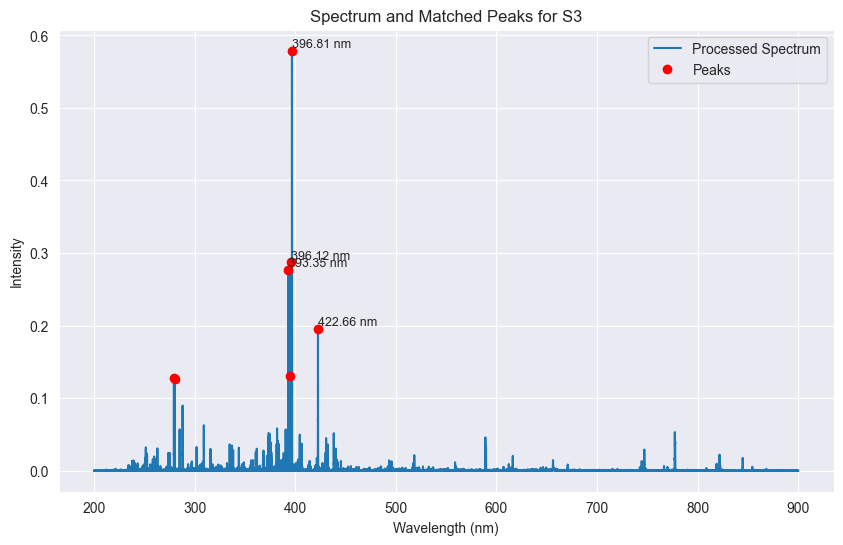

In [10]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

# Fungsi untuk mengambil spektrum yang diproses dari database processed_spectrum
def get_processed_spectrum(db_path, sample_name):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mengambil spektrum yang diproses untuk sampel tertentu
    query = """
        SELECT wavelength, intensity
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    cursor.execute(query, (sample_name,))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data spektrum ditemukan untuk sampel {sample_name}.")
        return np.array([]), np.array([])

    wavelengths, intensities = zip(*data)
    return np.array(wavelengths), np.array(intensities)

# Fungsi untuk mengambil data panjang gelombang untuk atom Ca dari database NIST (data1.db)
def get_nist_data_for_ca(db_path):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Query untuk mengambil data panjang gelombang dari NIST untuk Ca
    query = """
        SELECT "obs_wl_air(nm)"
        FROM spectrum_data
        WHERE element = 'Ca' AND sp_num = "2"
    """
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print("Tidak ada data NIST ditemukan untuk atom Ca.")
        return np.array([])

    # Mengambil hanya panjang gelombang dari hasil query
    nist_wavelengths = [float(wl[0]) for wl in data]
    return np.array(nist_wavelengths)

# Fungsi untuk mencari puncak pada spektrum yang diproses
def find_peaks_in_spectrum(wavelengths, intensities, prominence=0.1):
    peaks, _ = find_peaks(intensities, prominence=prominence)
    peak_wavelengths = wavelengths[peaks]
    peak_intensities = intensities[peaks]
    return peak_wavelengths, peak_intensities

# Fungsi untuk mencocokkan puncak spektrum dengan data NIST
def match_peaks_with_nist(peak_wavelengths, peak_intensities, nist_wavelengths, tolerance=0.1):
    matched_peaks = []
    for peak, intensity in zip(peak_wavelengths, peak_intensities):
        # Cari panjang gelombang NIST yang mendekati puncak spektrum dengan toleransi
        closest_nist = nist_wavelengths[np.abs(nist_wavelengths - peak) <= tolerance]
        if len(closest_nist) > 0:
            matched_peaks.append((peak, intensity, closest_nist[0]))  # Simpan pasangan puncak, intensitas, dan panjang gelombang NIST terdekat
    return matched_peaks

# Fungsi utama untuk mencari puncak dan mencocokkannya dengan data NIST untuk atom Ca
def find_and_match_peaks(db_processed, db_nist, sample_name, prominence=0.1, tolerance=0.1):
    # Ambil spektrum yang diproses untuk sampel tertentu
    wavelengths, intensities = get_processed_spectrum(db_processed, sample_name)

    if len(wavelengths) == 0:
        return  # Jika tidak ada data, hentikan eksekusi

    # Cari puncak pada spektrum yang diproses
    peak_wavelengths, peak_intensities = find_peaks_in_spectrum(wavelengths, intensities, prominence)

    # Ambil data panjang gelombang dari NIST untuk Ca
    nist_wavelengths = get_nist_data_for_ca(db_nist)

    # Cocokkan puncak spektrum dengan data NIST
    matched_peaks = match_peaks_with_nist(peak_wavelengths, peak_intensities, nist_wavelengths, tolerance)

    # Cetak hasil pencocokan
    print(f"Puncak yang cocok untuk {sample_name}:")
    print(f"{'Peak Wavelength (nm)':<25} {'Intensity':<15} {'Matched NIST Wavelength (nm)':<30}")
    print("-" * 70)
    for peak, intensity, nist_wl in matched_peaks:
        print(f"{peak:<25} {intensity:<15} {nist_wl:<30}")

    # Plot spektrum dengan puncak yang ditandai
    plt.figure(figsize=(10, 6))
    plt.plot(wavelengths, intensities, label="Processed Spectrum")
    plt.plot(peak_wavelengths, peak_intensities, 'ro', label="Peaks")

    # Tandai puncak yang cocok dengan data NIST
    for peak, intensity, nist_wl in matched_peaks:
        plt.text(peak, intensity, f"{peak:.2f} nm", fontsize=9, verticalalignment='bottom')

    plt.xlabel('Wavelength (nm)')
    plt.ylabel('Intensity')
    plt.title(f'Spectrum and Matched Peaks for {sample_name}')
    plt.legend()
    plt.grid(True)
    plt.show()

# Path ke database processed_spectrum dan NIST (data1.db)
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'

# Nama sampel yang ingin diproses (misalnya S3)
sample_name = 'S3'

# Panggil fungsi untuk menemukan puncak dan mencocokkannya dengan data NIST untuk atom Ca
find_and_match_peaks(db_processed, db_nist, sample_name, prominence=0.1, tolerance=1)

Element    sp_num    
--------------------
10B        1         
10B        2         
11B        1         
11B        2         
12C        1         
13C        1         
198Hg      1         
Ac         1         
Ac         2         
Ac         3         
Ac         4         
Ag         1         
Ag         2         
Ag         3         
Al         1         
Al         2         
Al         3         
Al         4         
Al         5         
Am         1         
Am         2         
Ar         1         
Ar         2         
Ar         3         
Ar         4         
Ar         5         
Ar         7         
Ar         8         
Ar         9         
Ar         10        
Ar         11        
Ar         13        
Ar         14        
Ar         15        
As         1         
As         2         
As         3         
As         4         
At         1         
Au         1         
Au         2         
Au         3         
B          1         
B          

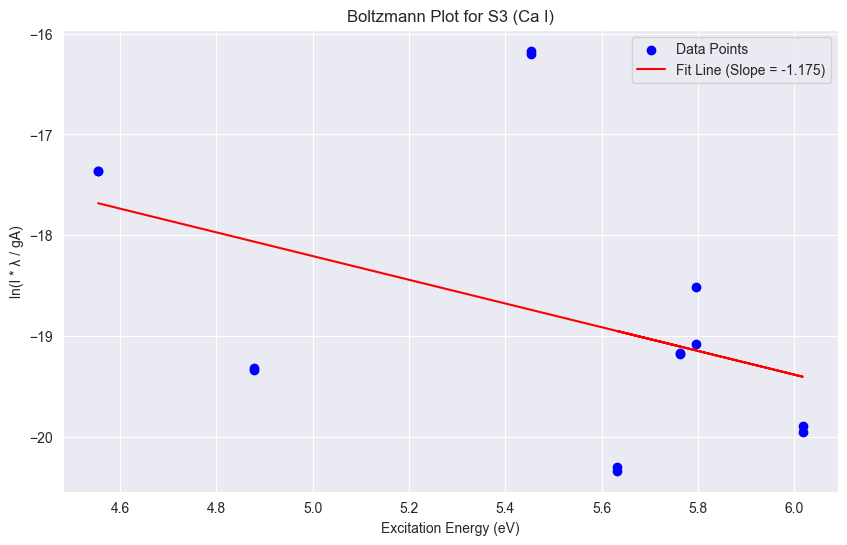

In [19]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Konstanta Fisika
k_B = 8.617333262145e-5  # Konstanta Boltzmann dalam eV/K
hc_in_eVnm = 1239.841984  # Konstanta hc dalam eV·nm (untuk konversi energi)

# Fungsi untuk mengambil data NIST untuk Ca I saja (kalsium netral)
def get_nist_data_for_ca_i(db_nist):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    # Query untuk mengambil data Ca I (Ca netral) dari NIST
    query = """
        SELECT "obs_wl_air(nm)", "Ek(cm-1)", "J_k", "gA(s^-1)"
        FROM spectrum_data
        WHERE element = 'Ca' AND sp_num = 1
    """
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print("Tidak ada data NIST ditemukan untuk Ca I (kalsium netral).")
        return []

    # Konversi energi dari cm^-1 ke eV (1 eV = 8065.544 cm^-1)
    nist_data = []
    for wl, Ek, Jk, gA in data:
        try:
            if wl and Ek and Jk and gA:  # Pastikan tidak ada nilai kosong
                wl = float(wl)
                Ek = float(Ek) / 8065.544  # Konversi ke eV
                Jk = float(Jk)
                gA = float(gA)
                nist_data.append((wl, Ek, Jk, gA))
        except ValueError:
            # Lewatkan entri jika ada masalah konversi
            continue
    
    return nist_data

# Fungsi untuk mengambil spektrum yang diproses dari database processed_spectrum dengan metadata
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None

    wavelengths, intensities, depth, location = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0]

# Fungsi untuk mencocokkan data panjang gelombang NIST dengan spektrum yang diproses
def match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance=0.0005):
    matched_data = []
    
    for wl_exp, intensity_exp in zip(processed_wavelengths, processed_intensities):
        for wl_nist, Ek, Jk, gA in nist_data:
            # Pastikan panjang gelombang eksperimen cocok dengan NIST dalam toleransi yang lebih ketat
            if abs(wl_exp - wl_nist) <= tolerance:
                matched_data.append((wl_nist, intensity_exp, Ek, Jk, gA))
                break  # Jika cocok, hentikan pencarian lebih lanjut untuk panjang gelombang ini

    return matched_data

# Fungsi untuk mencetak elemen dan sp_num dari database NIST
def print_element_and_sp_num(db_nist):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    query = """
        SELECT DISTINCT element, sp_num
        FROM spectrum_data
        ORDER BY element, sp_num
    """
    cursor.execute(query)
    data = cursor.fetchall()
    conn.close()

    if data:
        print(f"{'Element':<10} {'sp_num':<10}")
        print("-" * 20)
        for element, sp_num in data:
            print(f"{element:<10} {sp_num:<10}")
    else:
        print("Tidak ada data elemen yang ditemukan.")

# Fungsi untuk membuat plot Boltzmann, menghitung suhu plasma, dan mencetak data yang digunakan
def boltzmann_plot(db_processed, db_nist, sample_name, output_pdf='boltzmann_plot.pdf', tolerance=0.0005):
    # Ambil data NIST dan spektrum yang diproses dari database processed_spectrum
    nist_data = get_nist_data_for_ca_i(db_nist)  # Hanya mengambil data Ca I
    processed_wavelengths, processed_intensities, depth, location = get_processed_spectra_with_metadata(db_processed, sample_name)

    if not nist_data or len(processed_wavelengths) == 0:
        return  # Jika tidak ada data, hentikan eksekusi

    # Cocokkan data NIST dengan spektrum yang diproses menggunakan toleransi lebih ketat
    matched_data = match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance)

    if len(matched_data) == 0:
        print("Tidak ada puncak spektrum yang cocok dengan data NIST.")
        return

    # Print data yang digunakan untuk perhitungan
    print("Data yang digunakan (Ca I saja):")
    print(f"{'Wavelength (nm)':<15} {'Intensity':<12} {'Excitation Energy (eV)':<25} {'Degeneracy (J_k)':<20} {'Aki (s^-1)':<10}")
    print("-" * 90)
    for wl, intensity, Ek, Jk, Aki in matched_data:
        print(f"{wl:<15.4f} {intensity:<12.8f} {Ek:<25.4f} {Jk:<20.4f} {Aki:<10.2e}")

    # Siapkan data untuk plot Boltzmann: ln(I * λ / (g * A)) vs Ek
    wavelengths, intensities, energies, degeneracies, aki_values = zip(*matched_data)
    boltzmann_values = np.log((np.array(intensities) * np.array(wavelengths)) / (np.array(degeneracies) * np.array(aki_values)))

    # Buat plot Boltzmann (ln(I * λ / gA) vs Ek)
    plt.figure(figsize=(10, 6))
    plt.scatter(energies, boltzmann_values, color='blue', label="Data Points")
    
    # Lakukan fit linear
    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)

    # Plot garis fit linear
    plt.plot(energies, slope * np.array(energies) + intercept, 'r-', label=f'Fit Line (Slope = {slope:.3f})')

    # Hitung suhu plasma dari kemiringan (slope) plot Boltzmann
    T_plasma = -1 / (k_B * slope)
    print(f"Suhu plasma dari plot Boltzmann: {T_plasma:.2f} K")

    plt.xlabel('Excitation Energy (eV)')
    plt.ylabel('ln(I * λ / gA)')
    plt.title(f'Boltzmann Plot for {sample_name} (Ca I)')
    plt.legend()
    plt.grid(True)

    # Simpan plot ke file PDF
    plt.savefig(output_pdf, format='pdf')

    # Tampilkan plot
    plt.show()

# Path ke database processed_spectrum dan NIST (data1.db)
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'

# Cetak tabel elemen dan sp_num
print_element_and_sp_num(db_nist)

# Nama sampel yang ingin diproses (misalnya S3)
sample_name = 'S3'

# Panggil fungsi untuk membuat plot Boltzmann dan menghitung suhu plasma
boltzmann_plot(db_processed, db_nist, sample_name, output_pdf='boltzmann_plot_S3.pdf')

Data yang digunakan (Ca 1):
Wavelength (nm) Intensity    Excitation Energy (eV)    Degeneracy (J_k)     Aki (s^-1)
------------------------------------------------------------------------------------------
215.0800        0.00039261   5.76276231                1.00000000           1.80e+07  
215.0800        0.00039640   5.76276231                1.00000000           1.80e+07  
220.0730        0.00031982   5.63202656                1.00000000           4.59e+07  
220.0730        0.00030756   5.63202656                1.00000000           4.59e+07  
299.4960        0.00079830   6.01789823                1.00000000           1.10e+08  
299.4960        0.00084300   6.01789823                1.00000000           1.10e+08  
318.0520        0.00014202   5.79604835                1.00000000           8.70e+06  
318.0520        0.00024903   5.79604835                1.00000000           8.70e+06  
347.4760        0.00382642   5.45292010                1.00000000           1.40e+07  
347.4760   

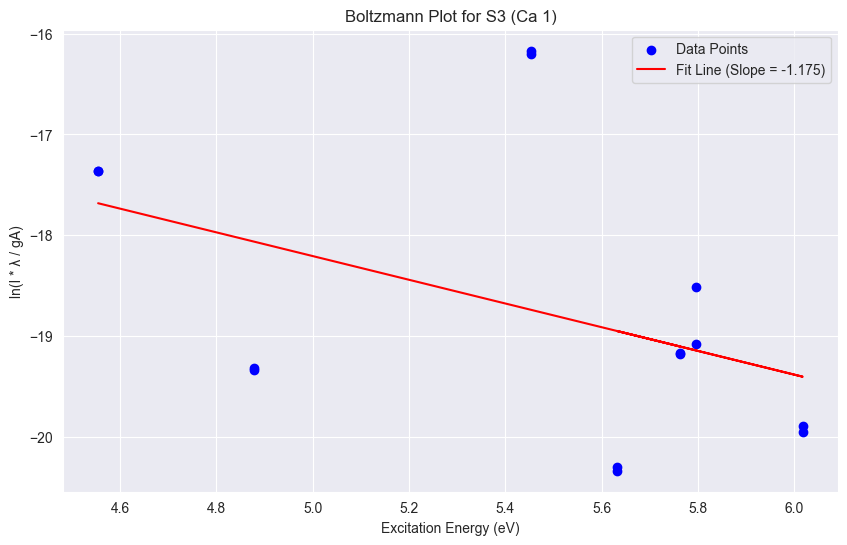

In [2]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Konstanta Fisika
k_B = 8.617333262145e-5  # Konstanta Boltzmann dalam eV/K
hc_in_eVnm = 1239.841984  # Konstanta hc dalam eV·nm (untuk konversi energi)

# Fungsi untuk mengambil data NIST berdasarkan elemen dan tingkat ionisasi (sp_num)
def get_nist_data_for_element(db_nist, element, ionization_stage):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    # Query untuk mengambil data NIST berdasarkan elemen dan tingkat ionisasi
    query = """
        SELECT "obs_wl_air(nm)", "Ek(cm-1)", "J_k", "gA(s^-1)"
        FROM spectrum_data
        WHERE element = ? AND sp_num = ?
    """
    cursor.execute(query, (element, ionization_stage))
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data NIST ditemukan untuk {element} {ionization_stage}.")
        return []

    # Konversi energi dari cm^-1 ke eV (1 eV = 8065.544 cm^-1)
    nist_data = []
    for wl, Ek, Jk, gA in data:
        try:
            if wl and Ek and Jk and gA:  # Pastikan tidak ada nilai kosong
                wl = float(wl)
                Ek = float(Ek) / 8065.544  # Konversi ke eV
                Jk = float(Jk)
                gA = float(gA)
                nist_data.append((wl, Ek, Jk, gA))
        except ValueError:
            continue  # Lewatkan entri jika ada masalah konversi
    
    return nist_data

# Fungsi untuk mengambil spektrum yang diproses dari database processed_spectrum dengan metadata
def get_processed_spectra_with_metadata(db_path, sample_name, lower_bound=None, upper_bound=None):
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    query = """
        SELECT wavelength, intensity, depth, location
        FROM processed_spectrum
        WHERE sample_name = ?
    """
    params = [sample_name]

    if lower_bound is not None and upper_bound is not None:
        query += " AND wavelength BETWEEN ? AND ?"
        params.extend([lower_bound, upper_bound])

    query += " ORDER BY wavelength"
    cursor.execute(query, params)
    data = cursor.fetchall()
    conn.close()

    if not data:
        print(f"Tidak ada data yang ditemukan untuk sampel: {sample_name}")
        return np.array([]), np.array([]), None, None

    wavelengths, intensities, depth, location = zip(*data)
    return np.array(wavelengths), np.array(intensities), depth[0], location[0]

# Fungsi untuk mencocokkan data panjang gelombang NIST dengan spektrum yang diproses
def match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance=0.0005):
    matched_data = []
    
    for wl_exp, intensity_exp in zip(processed_wavelengths, processed_intensities):
        for wl_nist, Ek, Jk, gA in nist_data:
            # Pastikan panjang gelombang eksperimen cocok dengan NIST dalam toleransi yang lebih ketat
            if abs(wl_exp - wl_nist) <= tolerance:
                matched_data.append((wl_nist, intensity_exp, Ek, Jk, gA))
                break  # Jika cocok, hentikan pencarian lebih lanjut untuk panjang gelombang ini

    return matched_data

# Fungsi untuk membuat plot Boltzmann, menghitung suhu plasma, dan mencetak data yang digunakan
def boltzmann_plot(db_processed, db_nist, sample_name, element, ionization_stage, output_pdf='boltzmann_plot.pdf', tolerance=0.0005):
    # Ambil data NIST untuk elemen dan tingkat ionisasi yang diinginkan
    nist_data = get_nist_data_for_element(db_nist, element, ionization_stage)
    processed_wavelengths, processed_intensities, depth, location = get_processed_spectra_with_metadata(db_processed, sample_name)

    if not nist_data or len(processed_wavelengths) == 0:
        return  # Jika tidak ada data, hentikan eksekusi

    # Cocokkan data NIST dengan spektrum yang diproses menggunakan toleransi lebih ketat
    matched_data = match_nist_with_spectrum(processed_wavelengths, processed_intensities, nist_data, tolerance)

    if len(matched_data) == 0:
        print(f"Tidak ada puncak spektrum yang cocok dengan data NIST untuk {element} {ionization_stage}.")
        return

    # Print data yang digunakan untuk perhitungan
    print(f"Data yang digunakan ({element} {ionization_stage}):")
    print(f"{'Wavelength (nm)':<15} {'Intensity':<12} {'Excitation Energy (eV)':<25} {'Degeneracy (J_k)':<20} {'Aki (s^-1)':<10}")
    print("-" * 90)
    for wl, intensity, Ek, Jk, Aki in matched_data:
        print(f"{wl:<15.4f} {intensity:<12.8f} {Ek:<25.8f} {Jk:<20.8f} {Aki:<10.2e}")

    # Siapkan data untuk plot Boltzmann: ln(I * λ / (g * A)) vs Ek
    wavelengths, intensities, energies, degeneracies, aki_values = zip(*matched_data)
    boltzmann_values = np.log((np.array(intensities) * np.array(wavelengths)) / (np.array(degeneracies) * np.array(aki_values)))

    # Buat plot Boltzmann (ln(I * λ / gA) vs Ek)
    plt.figure(figsize=(10, 6))
    plt.scatter(energies, boltzmann_values, color='blue', label="Data Points")
    
    # Lakukan fit linear
    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)

    # Plot garis fit linear
    plt.plot(energies, slope * np.array(energies) + intercept, 'r-', label=f'Fit Line (Slope = {slope:.3f})')

    # Hitung suhu plasma dari kemiringan (slope) plot Boltzmann
    T_plasma = -1 / (k_B * slope)
    print(f"Suhu plasma dari plot Boltzmann: {T_plasma:.2f} K")

    plt.xlabel('Excitation Energy (eV)')
    plt.ylabel('ln(I * λ / gA)')
    plt.title(f'Boltzmann Plot for {sample_name} ({element} {ionization_stage})')
    plt.legend()
    plt.grid(True)

    # Simpan plot ke file PDF
    plt.savefig(output_pdf, format='pdf')

    # Tampilkan plot
    plt.show()

# Path ke database processed_spectrum dan NIST (data1.db)
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'

# Nama sampel yang ingin diproses (misalnya S3)
sample_name = 'S3'

# Pilih elemen dan tingkat ionisasi yang diinginkan
element = ('Ca')  # Misalnya untuk Kalsium (Ca)
ionization_stage = 1# 1 untuk Ca I (netral), 2 untuk Ca II (ion pertama)

# Panggil fungsi untuk membuat plot Boltzmann dan menghitung suhu plasma
boltzmann_plot(db_processed, db_nist, sample_name, element, ionization_stage, output_pdf=f'boltzmann_plot_{element}_{ionization_stage}.pdf')

In [4]:
import numpy as np

# Konstanta Fisika
k_B = 8.617333262145e-5  # Konstanta Boltzmann dalam eV/K
hc_in_eVnm = 1239.841984  # Konstanta hc dalam eV·nm (untuk konversi energi)

def calculate_total_concentration(T_e, n_e, elements_data):
    """
    Menghitung konsentrasi total beberapa unsur dalam plasma LTE
    menggunakan suhu elektron (T_e), densitas elektron (n_e),
    dan data spektral masing-masing unsur.

    Parameter:
    - T_e: Suhu elektron dalam Kelvin
    - n_e: Densitas elektron dalam cm^-3
    - elements_data: Dictionary dengan unsur sebagai kunci dan data spektral sebagai nilai

    Mengembalikan:
    - Konsentrasi total setiap unsur dalam persen dari total sampel
    """
    total_concentrations = {}
    overall_concentration = 0  # Untuk menghitung total keseluruhan sampel

    for element, lines_data in elements_data.items():
        Z = 0  # Fungsi partisi untuk unsur ini
        total_concentration = 0

        # Hitung fungsi partisi Z(T_e) dan populasi setiap tingkat energi
        for intensity, wl, g_u, E_u, Aki in lines_data:
            if E_u > 50:  # Jika energi dalam cm^-1, konversi ke eV
                E_u = E_u / 8065.544

            # Fungsi partisi
            Z += g_u * np.exp(-E_u / (k_B * T_e))

            # Hitung konsentrasi relatif
            N_rel = (intensity * wl) / (g_u * Aki * np.exp(-E_u / (k_B * T_e)))
            total_concentration += N_rel

        # Simpan hasil konsentrasi total untuk unsur ini
        total_concentrations[element] = total_concentration
        overall_concentration += total_concentration  # Tambahkan ke total keseluruhan

    # Normalisasi konsentrasi menjadi persentase dari total keseluruhan
    for element in total_concentrations:
        total_concentrations[element] = (total_concentrations[element] / overall_concentration) * 100

    return total_concentrations

# Data spektral untuk beberapa unsur (misalnya, Ca I, Fe I, dll)
elements_data = {
    'Ca I': [
        (0.00039261, 215.0800, 1, 5.7628, 1.80e7),
        (0.00031982, 220.0730, 1, 5.6320, 4.59e7),
        (0.00079830, 299.4960, 1, 6.0179, 1.10e8)
    ],
    'Fe I': [
        (0.00123958, 380.193, 1, 5.1289, 2.70e8),
        (0.00238401, 381.584, 3, 5.2458, 1.60e8),
    ],
    # Tambahkan data untuk unsur lainnya jika ada
}

# Diketahui suhu elektron (Te) dan densitas elektron (Ne)
T_e = 8000  # Suhu elektron dalam Kelvin
n_e = 1e17  # Densitas elektron dalam cm^-3

# Hitung konsentrasi total dalam persen untuk setiap unsur dalam sampel
total_concentrations = calculate_total_concentration(T_e, n_e, elements_data)

# Print hasil konsentrasi total untuk setiap unsur
print("Konsentrasi total unsur dalam sampel (dalam persen):")
for element, concentration_percent in total_concentrations.items():
    print(f"{element}: {concentration_percent:.2f}%")

Konsentrasi total unsur dalam sampel (dalam persen):
Ca I: 85.13%
Fe I: 14.87%


Suhu plasma: 6691.96 K

Experimental Wavelength (nm) Intensity    Excitation Energy (eV)    Degeneracy (J_k)     Aki (s^-1)
----------------------------------------------------------------------------------------------------
422.6819                  N/A          2.93251193                1.00000000           6.54e+08  
428.2892                  0.00804756   4.77978398                2.00000000           2.17e+08  
429.9091                  0.00713219   4.76902835                1.00000000           1.40e+08  
430.7880                  0.03347656   4.76316824                0.00000000           1.99e+08  
442.4936                  0.01153295   4.68017991                1.00000000           1.49e+08  
443.5089                  0.00156707   4.68017991                1.00000000           1.03e+08  
445.4638                  0.01165108   4.68132701                3.00000000           6.10e+08  
616.2289                  0.01302857   3.91039898                1.00000000           1.43e+08  

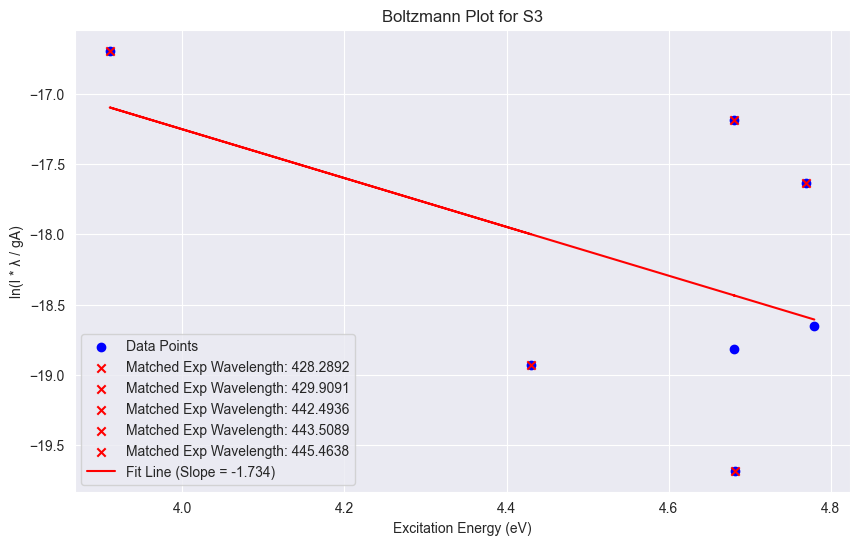

In [3]:
import sqlite3
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Konstanta Fisika
k_B = 8.617333262145e-5  # Konstanta Boltzmann dalam eV/K
hc_in_eVnm = 1239.841984  # Konstanta hc dalam eV·nm (untuk konversi energi)

# Fungsi untuk mengambil data NIST berdasarkan panjang gelombang NIST
def get_nist_data_for_wavelengths(db_nist, nist_wavelengths):
    conn = sqlite3.connect(db_nist)
    cursor = conn.cursor()

    nist_data = []
    for wl in nist_wavelengths:
        query = """
            SELECT "obs_wl_air(nm)", "Ek(cm-1)", "J_k", "gA(s^-1)"
            FROM spectrum_data
            WHERE "obs_wl_air(nm)" = ?
        """
        cursor.execute(query, (wl,))
        result = cursor.fetchone()
        if result:
            obs_wl, Ek, Jk, gA = result
            Ek = float(Ek) / 8065.544  # Konversi ke eV
            nist_data.append((obs_wl, Ek, float(Jk), float(gA)))
    conn.close()
    return nist_data

# Fungsi untuk mengambil intensitas dari spektrum yang diproses berdasarkan panjang gelombang eksperimental
def get_intensity_for_experimental_wavelengths(db_processed, sample_name, exp_wavelengths):
    conn = sqlite3.connect(db_processed)
    cursor = conn.cursor()

    intensities = []
    for wl_exp in exp_wavelengths:
        query = """
            SELECT intensity 
            FROM processed_spectrum
            WHERE sample_name = ? AND wavelength = ?
        """
        cursor.execute(query, (sample_name, wl_exp))
        result = cursor.fetchone()
        if result:
            intensities.append(float(result[0]))
        else:
            intensities.append(None)  # Jika tidak ada data, tambahkan None
    conn.close()
    return intensities

# Fungsi untuk menghitung suhu plasma dari data Boltzmann
def calculate_temperature(nist_data, intensities, exp_wavelengths):
    energies = []
    boltzmann_values = []
    matched_indices = []

    for i, (wl_nist, Ek, Jk, gA) in enumerate(nist_data):
        intensity = intensities[i]
        if intensity is None or Jk == 0 or gA == 0:
            continue  # Lewatkan jika tidak ada intensitas atau jika Jk atau gA = 0

        # Hitung ln(I * λ / (g * A)) dengan panjang gelombang eksperimen
        boltzmann_value = np.log((intensity * exp_wavelengths[i]) / (Jk * gA))
        energies.append(Ek)
        boltzmann_values.append(boltzmann_value)
        matched_indices.append(i)

    if len(boltzmann_values) < 2:
        print("Tidak cukup data untuk menghitung suhu plasma.")
        return None, None, None, matched_indices

    # Fit linear untuk mendapatkan slope
    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)

    # Hitung suhu plasma dari slope
    T_plasma = -1 / (k_B * slope)
    return T_plasma, energies, boltzmann_values, matched_indices

# Fungsi untuk membuat plot dan menghitung suhu plasma
def boltzmann_temperature_from_experimental(db_processed, db_nist, sample_name, nist_wavelengths, exp_wavelengths):
    # Langkah 1: Ambil data NIST untuk panjang gelombang tertentu
    nist_data = get_nist_data_for_wavelengths(db_nist, nist_wavelengths)

    # Langkah 2: Ambil intensitas dari panjang gelombang eksperimental dari spektrum yang diproses
    intensities = get_intensity_for_experimental_wavelengths(db_processed, sample_name, exp_wavelengths)

    # Langkah 3: Hitung suhu plasma dari data yang diperoleh
    T_plasma, energies, boltzmann_values, matched_indices = calculate_temperature(nist_data, intensities, exp_wavelengths)

    # Tampilkan hasil
    if T_plasma:
        print(f"Suhu plasma: {T_plasma:.2f} K")
    else:
        print("Gagal menghitung suhu plasma.")
        return

    # Print data yang digunakan untuk perhitungan, termasuk panjang gelombang eksperimental yang digunakan
    print(f"\n{'Experimental Wavelength (nm)':<25} {'Intensity':<12} {'Excitation Energy (eV)':<25} {'Degeneracy (J_k)':<20} {'Aki (s^-1)':<10}")
    print("-" * 100)
    for i, (wl_nist, Ek, Jk, gA) in enumerate(nist_data):
        intensity = intensities[i]
        wl_exp = exp_wavelengths[i]
        try:
            # Pastikan nilai bisa diformat sebagai float, jika tidak tampilkan "N/A"
            wl_exp = f"{float(wl_exp):.4f}"
            intensity = f"{float(intensity):.8f}" if intensity is not None else "N/A"
            Ek = f"{float(Ek):.8f}"
            Jk = f"{float(Jk):.8f}"
            gA = f"{float(gA):.2e}"
        except ValueError:
            wl_exp, intensity, Ek, Jk, gA = "N/A", "N/A", "N/A", "N/A", "N/A"
        print(f"{wl_exp:<25} {intensity:<12} {Ek:<25} {Jk:<20} {gA:<10}")

    # Plot Boltzmann: ln(I * λ / (g * A)) vs Ek
    plt.figure(figsize=(10, 6))
    
    # Plot semua titik
    plt.scatter(energies, boltzmann_values, color='blue', label="Data Points")
    
    # Tandai titik yang sesuai dengan panjang gelombang eksperimen
    for idx in matched_indices:
        if idx < len(energies):
            plt.scatter(energies[idx], boltzmann_values[idx], color='red', marker='x', label=f'Matched Exp Wavelength: {exp_wavelengths[idx]:.4f}')

    # Lakukan fit linear
    slope, intercept, r_value, p_value, std_err = linregress(energies, boltzmann_values)
    plt.plot(energies, slope * np.array(energies) + intercept, 'r-', label=f'Fit Line (Slope = {slope:.3f})')

    plt.xlabel('Excitation Energy (eV)')
    plt.ylabel('ln(I * λ / gA)')
    plt.title(f'Boltzmann Plot for {sample_name}')
    plt.legend()
    plt.grid(True)

    # Simpan plot ke file PDF
    plt.savefig('boltzmann_plot_experimental.pdf', format='pdf')

    # Tampilkan plot
    plt.show()

# Panjang gelombang eksperimental dan NIST yang akan digunakan
exp_wavelengths = [422.6819, 428.28918, 429.90909, 430.78802, 442.49362, 443.50888, 445.46378, 616.22894, 649.40063]
nist_wavelengths = [422.673, 428.301, 429.899, 430.774, 442.544, 443.569, 445.478, 616.217, 649.378]

# Path ke database
db_processed = 'processed_spectra.db'
db_nist = 'data1.db'

# Nama sampel yang ingin diproses (misalnya 'S2')
sample_name = 'S3'

# Panggil fungsi untuk menghitung suhu plasma dan tampilkan data
boltzmann_temperature_from_experimental(db_processed, db_nist, sample_name, nist_wavelengths, exp_wavelengths)

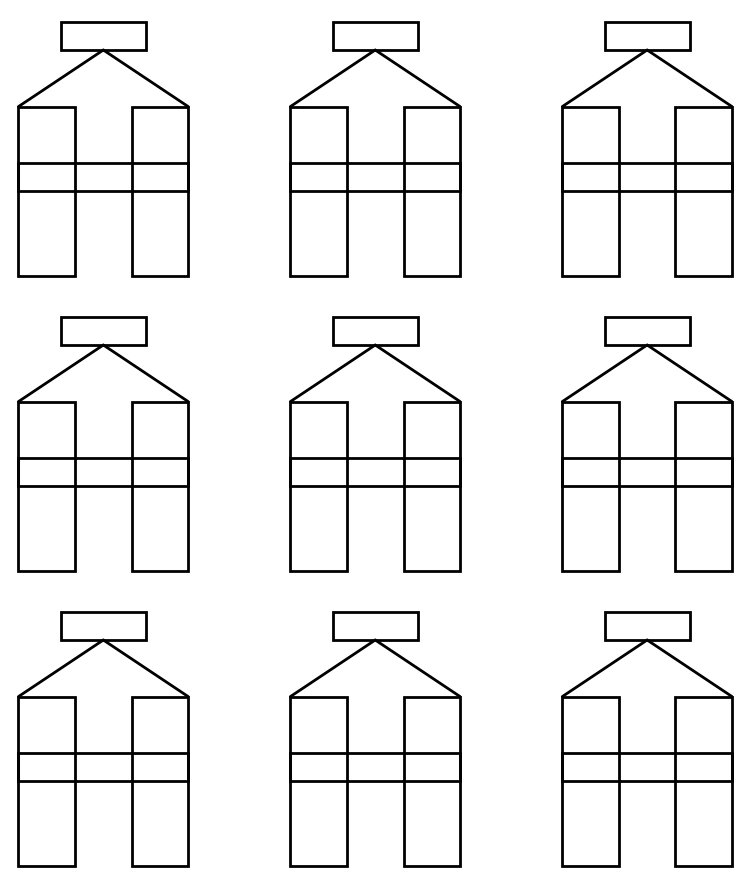

In [1]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Function to draw the custom "H" shape
def draw_custom_H(ax):
    # Draw the left and right legs of the "H"
    ax.add_patch(patches.Rectangle((0.2, 0.2), 0.2, 0.6, fill=False, edgecolor='black', linewidth=2))  # Left leg of H
    ax.add_patch(patches.Rectangle((0.6, 0.2), 0.2, 0.6, fill=False, edgecolor='black', linewidth=2))  # Right leg of H

    # Draw the middle connecting bar of the "H"
    ax.add_patch(patches.Rectangle((0.2, 0.5), 0.6, 0.1, fill=False, edgecolor='black', linewidth=2))  # Middle bar of H

    # Draw the slanted lines at the top to resemble an "A" shape
    ax.plot([0.2, 0.5], [0.8, 1.0], color='black', linewidth=2)  # Slant from left leg to the top middle
    ax.plot([0.8, 0.5], [0.8, 1.0], color='black', linewidth=2)  # Slant from right leg to the top middle

    # Draw the crossbar on top to finish the "A" style top
    ax.add_patch(patches.Rectangle((0.35, 1.0), 0.3, 0.1, fill=False, edgecolor='black', linewidth=2))  # Horizontal crossbar

# Create a figure and axis for a 3x3 grid of plots
fig, axs = plt.subplots(3, 3, figsize=(9, 9))

# Loop over the axes and draw the custom "H" in each subplot
for i in range(3):
    for j in range(3):
        draw_custom_H(axs[i, j])
        axs[i, j].set_aspect('equal')
        axs[i, j].set_axis_off()  # Hide the axes for each subplot

# Adjust the layout
plt.tight_layout()
plt.show()